Target:

Get the set-up right

*   Set Transforms
*   Set Data Loader
*   Set Basic Working Code
*   Set Basic Training  & Test Loop

Results:

*   Parameters: 6.3M
*   Best Training Accuracy: 99.99
*   Best Test Accuracy: 99.24

Analysis:

*   Extremely Heavy Model for such a problem
*   Model is over-fitting, but we are changing our model in the next step

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train phase transformation

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((.1307,), (.3081,))
                                       ])

#Test phase transformation
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((.1307,), (.3081,))
                                       ])

# Download Dataset, apply transforms and Creating Train/Test Split

In [ ]:
train_dataset = datasets.MNIST(root= './data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root= './data', train=False, transform=test_transforms, download=True)

## Check for device and set SEED value for reproducibility

In [ ]:
SEED = 1

#Check for CUDA?
cuda = torch.cuda.is_available()
print("Cuda is available ?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

Cuda is available ? True


# Define Dataloader Arguments & Load Train and Test datasets


DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [ ]:
# DataLoader arguments
dataloader_args = dict(batch_size=128, shuffle=True, num_workers=4, pin_memory=True) if cuda else dict(batch_size=64, shuffle=True)

# train and test dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
dir(train_dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

In [ ]:
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


C:\Users\Ravi\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Ravi\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


Text(0.5, 1.0, 'Label is: 9')

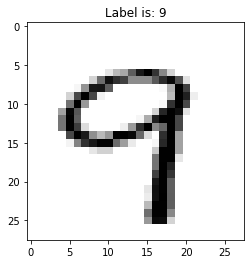

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train = train_dataset.train_data
train = train_dataset.transform(train.numpy())  # train.numpy is opposite of transform.ToTensor()


print('[Train]')
print(' - Numpy Shape:', train_dataset.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_dataset.train_data.size())
print(' - min:', torch.min(train))
print(' - max:', torch.max(train))
print(' - mean:', torch.mean(train))
print(' - std:', torch.std(train))
print(' - var:', torch.var(train))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

#Let's visualize some of the images
%matplotlib inline

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.title("Label is: "+str(labels[0].numpy().squeeze()))

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

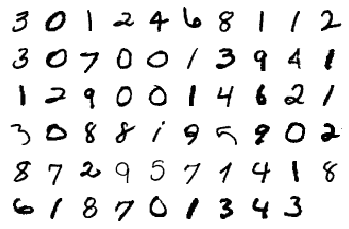

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images):
  plt.subplot(6, 10, index)
  plt.axis("off")
  plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")


# The model
Let's start with the model we first saw


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)          # output_image=28 RF=3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)         # output_image=28 RF=5
        self.pool1 = nn.MaxPool2d(2, 2)                      # output_image=14 RF=6
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)        # output_image=14 RF=10
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)       # output_image=14 RF=14
        self.pool2 = nn.MaxPool2d(2, 2)                      # output_image=7 RF=16
        self.conv5 = nn.Conv2d(256, 512, 3)                  # output_image=7 RF=24
        self.conv6 = nn.Conv2d(512, 1024, 3)                 # output_image=7 RF=32
        self.conv7 = nn.Conv2d(1024, 10, 3)                  # output_image=1 RF=40

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

Summarize Model

In [ ]:
from torchsummary import summary
device = torch.device("cuda" if cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

Training and Testing functions

In [ ]:
from tqdm import tqdm
import os
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
train_acc = 0
test_acc = 0
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader, position=0, leave=True)

  correct = 0
  processed = 0

  try:
      for batch_idx, (images, labels) in enumerate(pbar):
        # get samples
        images, labels = images.to(device), labels.to(device)
        # Init
        optimizer.zero_grad()
        #Predict
        y_pred = model(images)
        #Calculate loss
        loss = F.nll_loss(y_pred, labels)
        train_losses.append(loss)

        #Backpropagation
        loss.backward()

        #update weights
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        #check how many predictions are correct
        if cuda:
          correct += pred.cpu().eq(labels.cpu().view_as(pred)).sum().item()
        else:
          correct += pred.eq(labels.view_as(pred)).sum().item()
        
        processed += len(images) # 128 + 128 +128 ......till 60000 images

        train_acc = 100*correct / processed
        train_accuracy.append(train_acc)
        pbar.set_description(desc=f"EPOCH= {epoch} Loss= {loss.item() :0.4f} Batch_id= {batch_idx} Accuracy= {train_acc:0.2f}")
  finally:
    tqdm._instances.clear()
    os.system('cls') 
       
    
def test(model, device, test_loader):
  model.eval()
  

  correct = 0
  test_loss = 0
  
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
      # get samples
      images, labels = images.to(device), labels.to(device)
      
      #Predict
      y_pred = model(images)
      #Calculate loss and sum all the loss for one batch
      test_loss += F.nll_loss(y_pred, labels, reduction='sum').item()
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      #check how many predictions are correct
      if cuda:
        correct += pred.cpu().eq(labels.cpu().view_as(pred)).sum().item()
      else:
        correct += pred.eq(labels.view_as(pred)).sum().item()
      
     # processed += len(images) # 128 + 128 +128 ......till 10000 images

  test_loss /= len(test_loader.dataset)  # loss per epoch
  test_losses.append(test_loss)

  test_acc = 100*correct / len(test_loader.dataset)
  test_accuracy.append(train_acc)
  print(f"\nTest set: Average Loss= {test_loss :0.4f} Batch_id= {batch_idx} Accuracy= {correct}/{len(test_loader.dataset)} ({test_acc:0.2f}%)\n")



In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 5
for epoch in range(EPOCHS):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

EPOCH= 0 Loss= 0.0184 Batch_id= 468 Accuracy= 82.75: 100%|███████████████████████████| 469/469 [00:41<00:00, 11.18it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0612 Batch_id= 78 Accuracy= 9787/10000 (97.87%)



EPOCH= 1 Loss= 0.0039 Batch_id= 468 Accuracy= 98.17: 100%|███████████████████████████| 469/469 [00:42<00:00, 11.02it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0431 Batch_id= 78 Accuracy= 9865/10000 (98.65%)



EPOCH= 2 Loss= 0.0087 Batch_id= 468 Accuracy= 98.90: 100%|███████████████████████████| 469/469 [00:42<00:00, 11.16it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0335 Batch_id= 78 Accuracy= 9877/10000 (98.77%)



EPOCH= 3 Loss= 0.0306 Batch_id= 468 Accuracy= 99.19: 100%|███████████████████████████| 469/469 [00:41<00:00, 11.19it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average Loss= 0.0296 Batch_id= 78 Accuracy= 9902/10000 (99.02%)



EPOCH= 4 Loss= 0.0408 Batch_id= 468 Accuracy= 99.41: 100%|███████████████████████████| 469/469 [00:42<00:00, 11.15it/s]



Test set: Average Loss= 0.0325 Batch_id= 78 Accuracy= 9911/10000 (99.11%)

